#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 67.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
# Импортируем библиотеки 
import os 
import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import(
    GridSearchCV, 
    train_test_split,
    TimeSeriesSplit, 
    cross_val_score 
)
STATE=42
SIZE=0.1

In [3]:
# Настроим метрику для RMSE
def RMSE(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [4]:
# Загрузка данных  
dataset_dir = '/datasets'
file_name = 'taxi.csv'
file_path = os.path.join(dataset_dir, file_name)
dataset_name = 'data'
if os.path.exists(file_path):
    data = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
    print(f"Файл {file_name} загружен успешно:")
    display(data.head())
else:
    print(f"Файл {file_name} не найден")

Файл taxi.csv загружен успешно:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.sort_index(inplace=True)


In [6]:
display(data)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


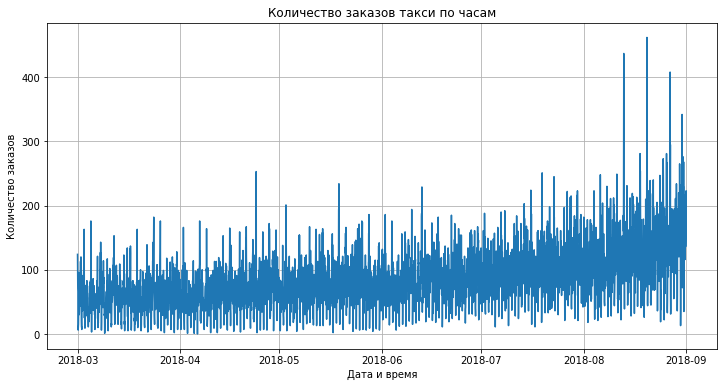

In [7]:
# Ресемплирование данных по одному часу 
data = data.resample('1H').sum()

# Построение графика с настройками
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['num_orders'], label='Количество заказов')
plt.title('Количество заказов такси по часам')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show();

**Мы выполняем ресемплирование данных с шагом в один час, так как наша задача — предсказать количество заказов такси на ближайший час. Для этого все заказы в пределах каждого часа суммируются.**

## Анализ

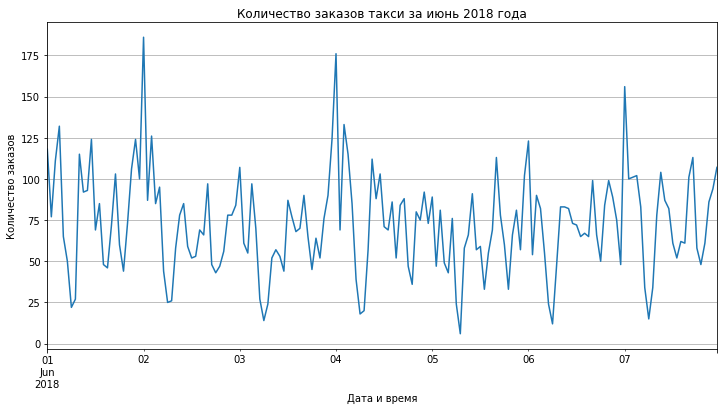

In [8]:
# Рассмотрим период меньше
# Построение графика за июнь 2018 года
plt.figure(figsize=(12, 6))
data['2018-06-01':'2018-06-07']['num_orders'].plot()
plt.title('Количество заказов такси за июнь 2018 года')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

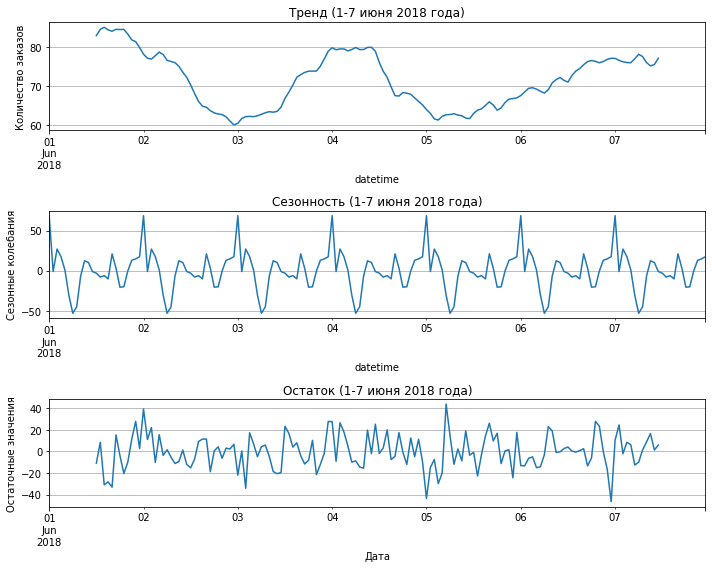

In [9]:
decomposed_data_taxi = seasonal_decompose(data['2018-06-01':'2018-06-07'])


plt.figure(figsize=(10, 8))
# Тренд
plt.subplot(311)
decomposed_data_taxi.trend.plot(ax=plt.gca())
plt.title('Тренд (1-7 июня 2018 года)')
plt.ylabel('Количество заказов')
plt.grid(True)
# Сезонность
plt.subplot(312)
decomposed_data_taxi.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (1-7 июня 2018 года)')
plt.ylabel('Сезонные колебания')
plt.grid(True)
# Остаток
plt.subplot(313)
decomposed_data_taxi.resid.plot(ax=plt.gca())
plt.title('Остаток (1-7 июня 2018 года)')
plt.xlabel('Дата')
plt.ylabel('Остаточные значения')
plt.grid(True)
plt.tight_layout()
plt.show()

1. Тренд
**На графике тренда видно, что количество заказов на такси в течение первой недели июня 2018 года имеет увеличиваются и снижаются. В начале недели количество заказов постепенно снижалось, достигнув минимума около 3 июня, а затем снова начало расти к концу недели.
Это может указывать на недельный спрос — снижение спроса в выходные дни и увеличение ближе к рабочим дням.**

2. Сезонность
**График сезонности показывает повторяющиеся колебания в течение каждого дня, что указывает на ежедневные циклы спроса.
Предположу, что пики на графике сезонности  соответствуют утренним и вечерним часам, когда обычно наблюдается наибольшее количество поездок.**

3. Выводы о стационарности:
**Тренд и сезонность указывают на то, что временной ряд не является стационарным, так как присутствует изменяющийся тренд и сезонные колебания.
Остаток содержит некоторое количество шума.**

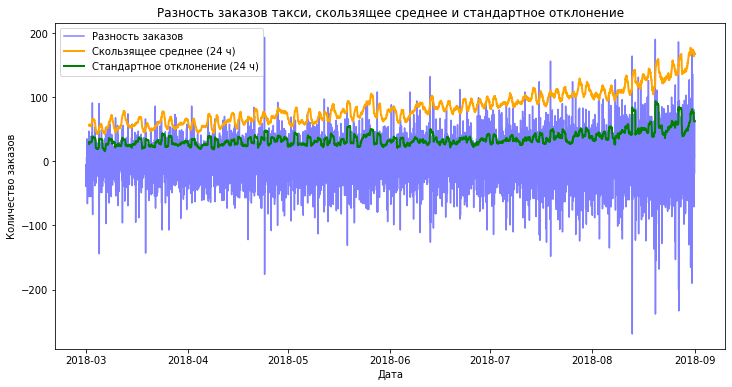

In [10]:
# Преобразование данных с использованием разности
data_shift = data - data.shift()

# Окно размером 24 означает, что мы вычисляем скользящее среднее и стандартное отклонение на основе суток.
# Добавляем скользящее среднее и стандартное отклонение 
data_shift['mean'] = data['num_orders'].rolling(24).mean()
data_shift['std'] = data['num_orders'].rolling(24).std()
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data_shift.index, data_shift['num_orders'], label='Разность заказов', color='blue', alpha=0.5)
plt.plot(data_shift.index, data_shift['mean'], label='Скользящее среднее (24 ч)', color='orange', linewidth=2)
plt.plot(data_shift.index, data_shift['std'], label='Стандартное отклонение (24 ч)', color='green', linewidth=2)

plt.title('Разность заказов такси, скользящее среднее и стандартное отклонение')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [11]:
# Создадим признаки для обучения модели
# Наблюдаются повторяющиеся закономерности через каждые 24 часа
# Для сглаживания шума и выявления более долгосрочных трендов мы будем использовать скользящее среднее с окном в 48 часов
max_lag = 24
rolling_mean_size = 48
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(data, 'num_orders', max_lag, rolling_mean_size)

# Разделение на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=SIZE, random_state=STATE)
train = train.dropna()

# Разделение на признаки и целевую переменную
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']


## Обучение

### Линейная регрессия

In [13]:
start_time = time.time()
# Настроим TimeSeriesSplit
my_cv = TimeSeriesSplit(n_splits=8)
# Инициализируем модель линейной регрессии
regressor = LinearRegression()
print('# Train for root_mean_squared_error\n')
# Оценка модели с использованием кросс-валидации по метрике RMSE
regression_cv_score = (cross_val_score(
    regressor, 
    features_train, 
    target_train, 
    cv=my_cv, 
    scoring='neg_mean_squared_error'
).mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', regression_cv_score)
# Вычисляем и выводим время выполнения
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 27.146562377544374
Время выполнения: 1.54 секунд


In [14]:
start_time = time.time()
# Инициализация модели с масштабированием
linear_regressor = LinearRegression()
standard_scaler = StandardScaler()
# Создаём Pipeline 
pipeline_regressor = Pipeline([
    ("scaler", standard_scaler), 
    ("regressor", linear_regressor)
])
print('# Train for root_mean_squared_error\n')
# Оценка модели с использованием кросс-валидации по метрике RMSE
cv_rmse_scaled = cross_val_score(
    pipeline_regressor,
    features_train, 
    target_train, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
).mean() * -1

print(f'Mean RMSE from CV of LinearRegression with Scaler = {cv_rmse_scaled:.2f}')
# Вычисляем и выводим время выполнения
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression with Scaler = 26.00
Время выполнения: 0.99 секунд


### CatBoost


In [15]:
# Задаём параметры для модели CatBoostRegressor
cb_params = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'random_state': [STATE]
}

my_cv = TimeSeriesSplit(n_splits=3)

# Инициализация модели
catboost_model = CatBoostRegressor(verbose=0)

# Подбор гиперпараметров с использованием GridSearchCV
print('# Подбор гиперпараметров для CatBoostRegressor...\n')

cb_grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=cb_params,
    scoring=RMSE_score,
    cv=my_cv,
    n_jobs=-1
)
cb_grid_search.fit(features_train, target_train)
best_params_cb = cb_grid_search.best_params_
cb_best_score = (-cb_grid_search.best_score_) ** 0.5
print(f'Лучший RMSE для CatBoostRegressor на кросс-валидации = {cb_best_score:.2f}')


# Извлечение лучших параметров и результатов кросс-валидации
best_params = cb_grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

# Извлекаем результаты из `cv_results_`
results = cb_grid_search.cv_results_
means = results['mean_test_score']
stds = results['std_test_score']
params = results['params']

print("\nДетализированные результаты GridSearchCV:\n")
for mean, std, param in zip(means, stds, params):
    rmse = (-mean) ** 0.5  # Преобразуем из отрицательного MSE в RMSE
    print(f"RMSE: {rmse:.4f} ± {std:.4f} для параметров: {param}")



# Подбор гиперпараметров для CatBoostRegressor...

Лучший RMSE для CatBoostRegressor на кросс-валидации = 5.14
Лучшие параметры: {'depth': 6, 'learning_rate': 0.03, 'random_state': 42}

Детализированные результаты GridSearchCV:

RMSE: 5.1628 ± 3.6062 для параметров: {'depth': 4, 'learning_rate': 0.03, 'random_state': 42}
RMSE: 5.2183 ± 3.7716 для параметров: {'depth': 4, 'learning_rate': 0.1, 'random_state': 42}
RMSE: 5.1449 ± 3.6769 для параметров: {'depth': 6, 'learning_rate': 0.03, 'random_state': 42}
RMSE: 5.1746 ± 3.4881 для параметров: {'depth': 6, 'learning_rate': 0.1, 'random_state': 42}
RMSE: 5.2648 ± 3.8708 для параметров: {'depth': 10, 'learning_rate': 0.03, 'random_state': 42}
RMSE: 5.3242 ± 3.9926 для параметров: {'depth': 10, 'learning_rate': 0.1, 'random_state': 42}


In [16]:
# Обучение лучшей модели с найденными параметрами (CatBoostRegressor)
best_model = CatBoostRegressor(**best_params_cb, verbose=0)

# Замер времени и обучение модели
start_time = time.time()
best_model.fit(features_train, target_train)
end_time = time.time()
print(f"\nВремя обучения лучшей модели: {end_time - start_time:.2f} секунд")

# Оценка модели на тестовой выборке
predictions = best_model.predict(features_test)
final_rmse = np.sqrt(mean_squared_error(target_test, predictions))
print(f"RMSE на тестовой выборке для лучшей модели: {final_rmse:.2f}")


Время обучения лучшей модели: 6.90 секунд
RMSE на тестовой выборке для лучшей модели: 41.86


### DesicionTreeRegressor

In [17]:
# Инициализация модели DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor()

# Определяем список значений для max_depth
max_depth_list = [x for x in range(2, 15)]

# Определяем гиперпараметры для подбора
dt_hyperparams = [{'criterion': ['squared_error'], 
                   'max_depth': max_depth_list, 
                   'random_state': [STATE]}]

print('# Подбор гиперпараметров для модели DecisionTreeRegressor...\n')

# Инициализация GridSearchCV
dt_grid_search = GridSearchCV(
    estimator=dt_regressor, 
    param_grid=dt_hyperparams, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# Подбор гиперпараметров 
dt_grid_search.fit(features_train, target_train)

# Извлечение лучших параметров и вывод результатов
best_params_dt = dt_grid_search.best_params_
dt_best_score = (-dt_grid_search.best_score_) ** 0.5
print(f'Лучший RMSE для DecisionTreeRegressor на кросс-валидации = {dt_best_score:.2f}')
print("Лучшие параметры на обучающем наборе данных:", best_params_dt)

# Извлекаем детализированные результаты из cv_results_
results = dt_grid_search.cv_results_
means = results['mean_test_score']
stds = results['std_test_score']
params = results['params']

print("\nДетализированные результаты GridSearchCV:\n")
for mean, std, param in zip(means, stds, params):
    rmse = (-mean) ** 0.5  
    print(f"RMSE: {rmse:.4f} ± {std:.4f} для параметров: {param}")

# Подбор гиперпараметров для модели DecisionTreeRegressor...

Лучший RMSE для DecisionTreeRegressor на кросс-валидации = 29.43
Лучшие параметры на обучающем наборе данных: {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 42}

Детализированные результаты GridSearchCV:

RMSE: 31.3864 ± 450.8216 для параметров: {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 42}
RMSE: 29.6692 ± 366.1377 для параметров: {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 42}
RMSE: 29.6545 ± 390.8274 для параметров: {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 42}
RMSE: 29.5510 ± 356.4429 для параметров: {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 42}
RMSE: 29.4327 ± 336.5153 для параметров: {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 42}
RMSE: 30.0163 ± 338.5742 для параметров: {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 42}
RMSE: 30.1398 ± 323.7355 для параметров: {'criterion': 'squared_error

**Вывод :**

**Мы обучили 3 модели и подобрали гиперпараметры методом грид серч.**

## Тестирование

In [18]:
# Тест на адекватность модели
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 58.856


In [19]:
def graph(predictions):
    # Создание DataFrame с фактическими и предсказанными значениями
    model_data = pd.DataFrame({"Фактическое значение": target_test, "Прогноз": predictions}, index=target_test.index)
    # Построение графика
    plt.figure(figsize=(18, 6))
    model_data.plot(ax=plt.gca(), alpha=0.7)
    plt.title("Прогноз vs Фактические значения (весь период)")
    plt.xlabel("Дата")
    plt.ylabel("Количество заказов")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
def feature_importances(model, features_train):
    importances = model.feature_importances_
    feature_names = features_train.columns
    not_null_indices = [i for i, importance in enumerate(importances) if importance > 0]
    not_null_importances = importances[not_null_indices]
    not_null_features = feature_names[not_null_indices]

    # Построение графика
    plt.figure(figsize=(15, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(not_null_importances)), not_null_importances, color="b")
    plt.xticks(range(len(not_null_importances)), not_null_features, rotation=90)
    plt.tight_layout()
    plt.show()

In [21]:
start_time = time.time()
# Инициализация модели линейной регрессии
model_1 = LinearRegression()

# Обучение модели
model_1.fit(features_train, target_train)

# Прогнозирование на тестовой выборке
lr_predictions = model_1.predict(features_test)

# Вычисление метрики RMSE
model_1_rmse = round(np.sqrt(mean_squared_error(target_test, lr_predictions)), 3)
print('RMSE модели Линейной регрессии:', model_1_rmse)

# Замеряем время выполнения
end_time = time.time()
print(f"\nВремя выполнения обучения и прогнозирования: {end_time - start_time:.2f} секунд")

RMSE модели Линейной регрессии: 44.893

Время выполнения обучения и прогнозирования: 0.15 секунд


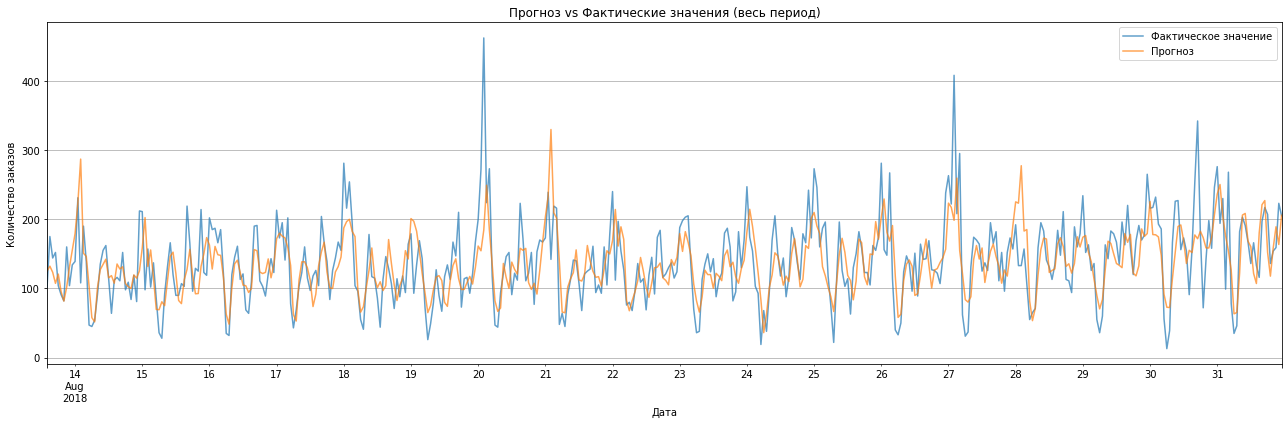

In [22]:
graph(lr_predictions)

In [23]:
# Оптимальные гиперпараметры на основе результатов GridSearchCV
best_params = {
    'depth': 6,
    'learning_rate': 0.03,
    'random_state': STATE
}

# Замер времени на обучение модели
print("\n# Обучение модели CatBoostRegressor с оптимальными гиперпараметрами...\n")
start_time = time.time()

# Обучаем модель на оптимальных гиперпараметрах
model_2 = CatBoostRegressor(
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    random_state=best_params['random_state'],
    verbose=False
)

# Обучение модели
model_2.fit(features_train, target_train)

# Замер времени после обучения
end_time = time.time()

# Прогнозирование на тестовой выборке
cb_predictions = model_2.predict(features_test)

# Вычисление метрики RMSE
model_2_rmse = round(np.sqrt(mean_squared_error(target_test, cb_predictions)), 3)
print(f'RMSE модели CatBoostRegressor на тестовой выборке: {model_2_rmse}')
print(f"\nВремя обучения модели: {end_time - start_time:.2f} секунд")



# Обучение модели CatBoostRegressor с оптимальными гиперпараметрами...

RMSE модели CatBoostRegressor на тестовой выборке: 41.859

Время обучения модели: 7.11 секунд


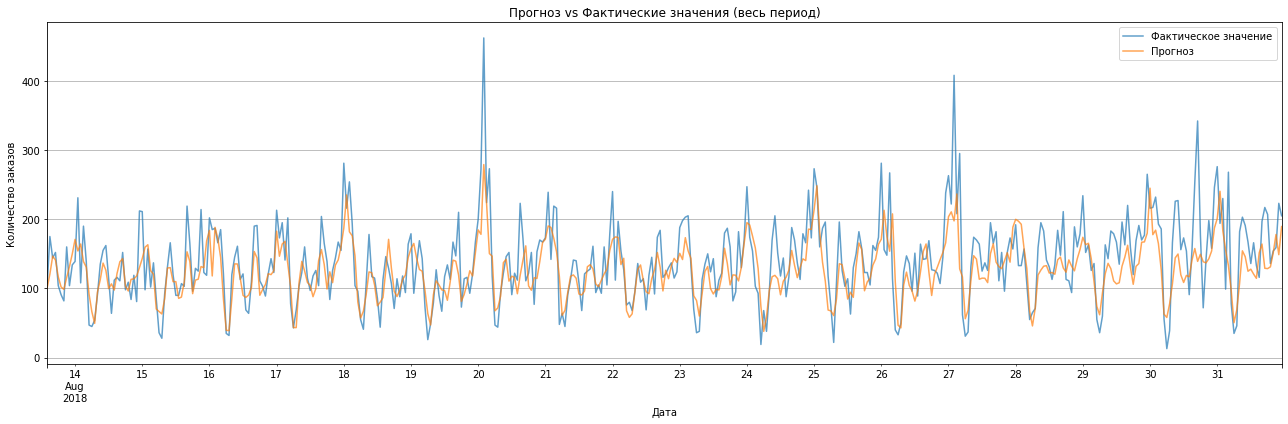

In [24]:
graph(cb_predictions)

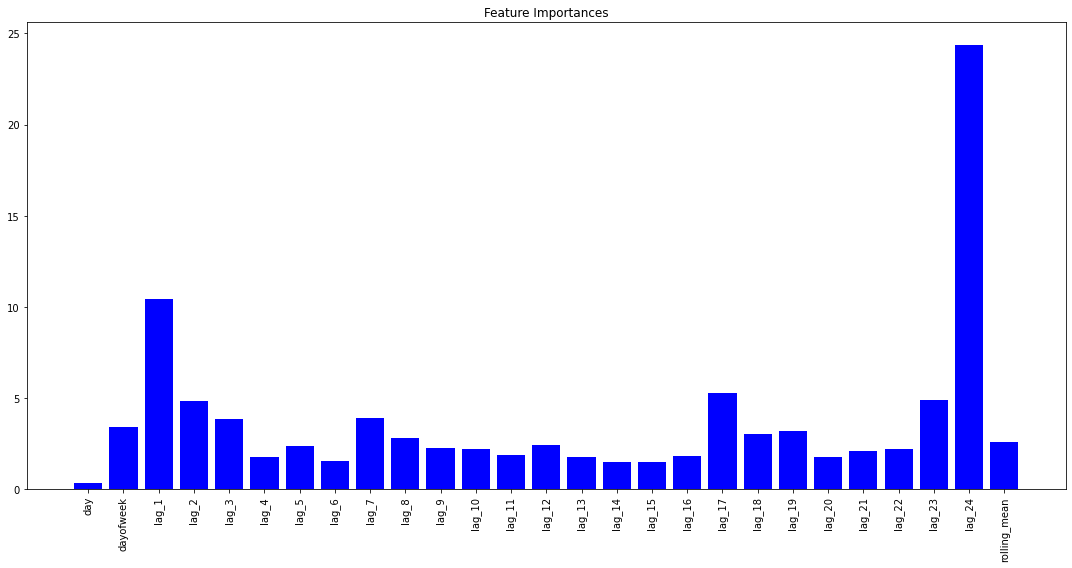

In [25]:
feature_importances(model_2, features_train)

In [26]:
# Замер времени на обучение модели
start_time = time.time()
# Инициализация модели DecisionTreeRegressor с оптимальными параметрами
model_3 = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=6,
    random_state=STATE
)

# Обучение модели
model_3.fit(features_train, target_train)

# Прогнозирование на тестовой выборке
dt_predictions = model_3.predict(features_test)

# Вычисление метрики RMSE
model_3_rmse = round(np.sqrt(mean_squared_error(target_test, dt_predictions)), 3)
print('RMSE модели DecisionTreeRegressor с оптимальными параметрами:', model_3_rmse)

# Замеряем время выполнения
end_time = time.time()
print(f"\nВремя выполнения обучения и прогнозирования: {end_time - start_time:.2f} секунд")

RMSE модели DecisionTreeRegressor с оптимальными параметрами: 58.363

Время выполнения обучения и прогнозирования: 0.04 секунд


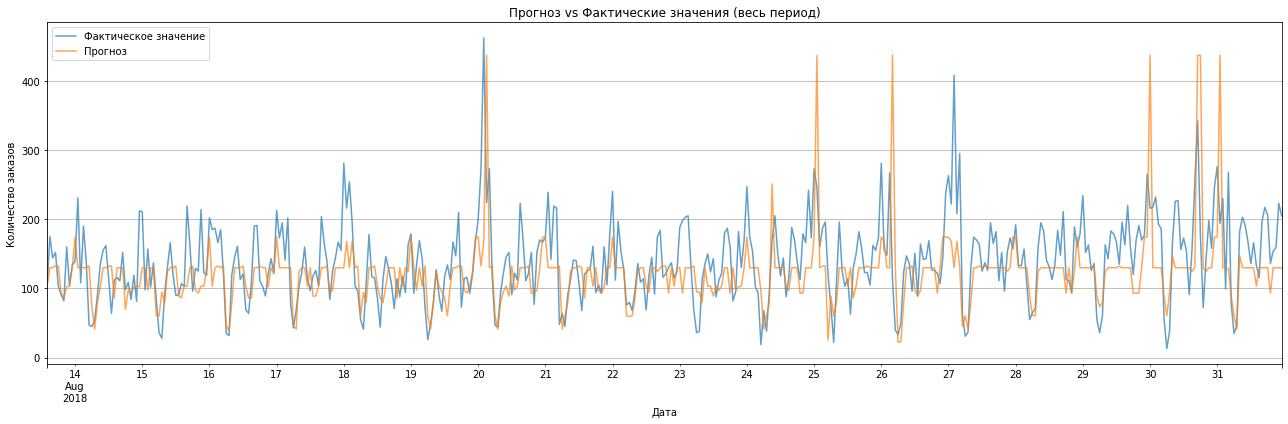

In [27]:
graph(dt_predictions)

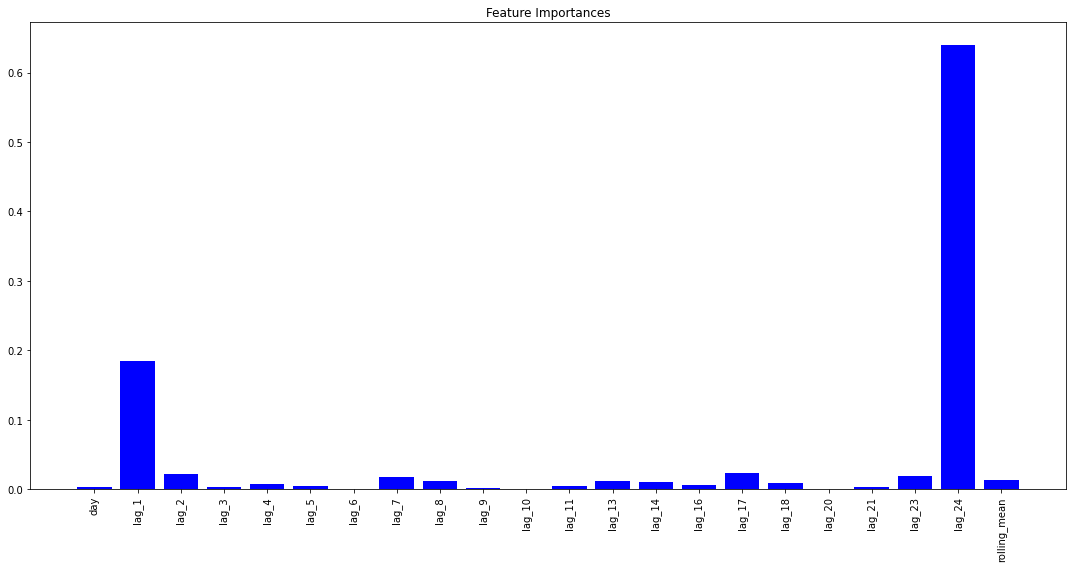

In [28]:
feature_importances(model_3, features_train)

In [29]:
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))
print('RMSE модели Линейной регрессии:', model_1_rmse)
print('RMSE модели DecisionTreeRegressor:', model_3_rmse)
print('RMSE модели CatBoostRegressor:', model_2_rmse)


RMSE для проверки модели на адекватность: 58.856
RMSE модели Линейной регрессии: 44.893
RMSE модели DecisionTreeRegressor: 58.363
RMSE модели CatBoostRegressor: 41.859


In [30]:
# Финальная оценка на тестовой выборке только для лучшей модели
print("\n# Оценка на тестовой выборке для лучшей модели (CatBoostRegressor)")
predictions = best_model.predict(features_test)
final_rmse = np.sqrt(mean_squared_error(target_test, predictions))
print(f"RMSE на тестовой выборке для лучшей модели: {final_rmse:.2f}")



# Оценка на тестовой выборке для лучшей модели (CatBoostRegressor)...
RMSE на тестовой выборке для лучшей модели: 41.86


# Вывод:

1. Загрузка данных и предварительная обработка
На начальном этапе была выполнена загрузка исходных данных и их подготовка для обучения моделей.

2. Создание дополнительных признаков
Для улучшения точности предсказания в исходный датасет были добавлены следующие признаки:

- День месяца (day)
- День недели (dayofweek)
- lag_features для учёта зависимости текущих значений от предыдущих 24 часов
- Скользящее среднее rolling_mean с окном 48 часов для сглаживания данных и выявления долгосрочных трендов
Эти дополнительные признаки помогли улучшить качество прогнозов.

3. Подбор гиперпараметров и обучение моделей
На основе дополненного датасета были настроены гиперпараметры для различных моделей:

- LinearRegression

- DecisionTreeRegressor

- CatBoostRegressor

Для каждой модели были подобраны оптимальные параметры, что позволило улучшить точность предсказаний.

4. Тестирование моделей и оценка результатов
После добавления новых признаков и оптимизации гиперпараметров, модели прошли финальное тестирование на тестовой выборке. 

RMSE для проверки модели на адекватность: 58.856
Это значение было рассчитано на основе dummy модели, которая использует предсказание на основе предыдущих значений. Высокое значение RMSE указывает на то, что более сложные модели могут значительно улучшить предсказания.

RMSE модели Линейной регрессии: 44.893
Линейная регрессия показала хороший результат, улучшив метрику по сравнению с dummy моделью.

RMSE модели DecisionTreeRegressor: 58.363
Модель решающего дерева показала результат, схожий с наивной моделью, что говорит о том что она неспособна учитывать сложные временные зависимости.

RMSE модели CatBoostRegressor: 41.859
CatBoostRegressor продемонстрировал наилучший результат среди всех протестированных моделей и смог значительно улучшить точность предсказания.


**Благодаря добавлению новых признаков и оптимизации гиперпараметров, модель CatBoostRegressor достигла наилучших результатов с RMSE = 41.859, это удовлетворяет критерию целевое значение RMSE ≤ 48.
Модель CatBoostRegressor может быть рекомендована для использования в компании «Чётенькое такси» для прогнозирования количества заказов на следующий час**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48